## 1. Data Exploration

In [64]:
%pip install -r requirements.txt

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.3-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached wrapt-1.17.2-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
  Using cached grpcio-1.69.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.9 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached h5py-3.12.1-cp39-cp39-manylin

In [65]:
import os
import pandas as pd

data_path = os.path.join("CYTECH_AirLiquide", "CYTECH")
original_data_path = os.path.join(data_path, "donnees historiques", "prix")
synthetic_data_path = os.path.join(data_path, "scenarios synthetiques", "prix")
synthetic_data_filenames = os.listdir(synthetic_data_path)

In [66]:
original_data = pd.read_parquet(os.path.join(original_data_path, "hourly_day_ahead_prices_2017_2020.parquet"))
original_data.head()

,price
date,
2016-12-31 23:00:00+00:00,58.82
2017-01-01 00:00:00+00:00,58.23
2017-01-01 01:00:00+00:00,51.95
2017-01-01 02:00:00+00:00,47.27
2017-01-01 03:00:00+00:00,45.49


In [67]:
print(f"Original data has {len(original_data)} hours of data")
print(f"Synthetic data has {len(synthetic_data_filenames)} scenarios")
lengths = []
for f in synthetic_data_filenames:
    synthetic_data = pd.read_parquet(os.path.join(synthetic_data_path, f))
    lengths.append(len(synthetic_data))
for l in list(set(lengths)):
    percentage = round(100*lengths.count(l)/len(synthetic_data_filenames))
    print(f"{percentage}% of synthetic scenarios are {l} hours long")

Original data has 35064 hours of data
Synthetic data has 154 scenarios
100% of synthetic scenarios are 34944 hours long


In [68]:
synthetic_data = pd.read_parquet(os.path.join(synthetic_data_path, synthetic_data_filenames[0]))
synthetic_data.head()

,price,dayofweek,hourofday
0,31.66,0,0
1,31.06,0,1
2,27.81,0,2
3,27.54,0,3
4,25.04,0,4


count    35064.000000
mean        41.697606
std         18.600285
min        -75.820000
25%         30.180000
50%         39.900000
75%         51.422500
max        259.950000
Name: price, dtype: float64


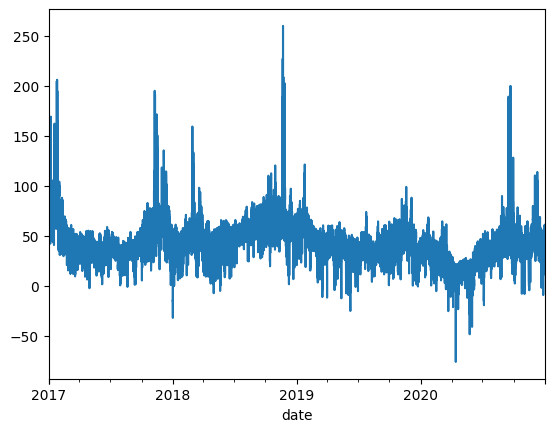

In [69]:
import numpy as np

original_series = original_data["price"]
print(original_series.describe())
original_series.plot()
original_series = np.array(original_series)

count    34944.000000
mean        41.356660
std         17.265847
min        -48.170000
25%         30.550000
50%         39.630000
75%         50.720000
max        259.950000
Name: price, dtype: float64


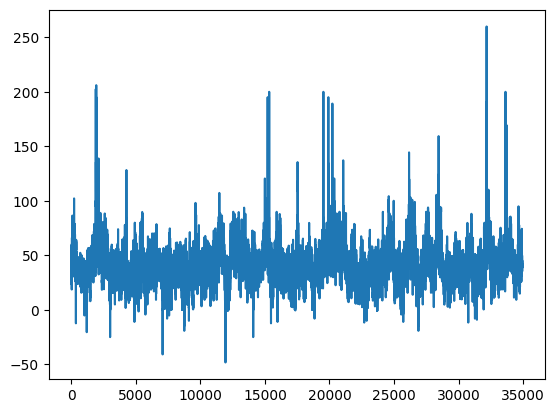

In [70]:
synthetic_series = synthetic_data["price"]
print(synthetic_series.describe())
synthetic_series.plot()
synthetic_data = np.array(synthetic_series)

## 2. Basic augmentation methods

Cette section est inspirée de [cette page](https://maddevs.io/writeups/basic-data-augmentation-method-applied-to-time-series/) (source issue du sujet).

In [71]:
import numpy as np
import matplotlib.pyplot as plt

def add_gaussian_noise(time_series, mean=0.0, stddev=1.0):
     # Gaussian noise generation
    noise = np.random.normal(mean, stddev, len(time_series))
    # Adding noise to the original time series
    noisy_series = time_series + noise
    return noisy_series

augmented_series = add_gaussian_noise(original_series, mean=0.0, stddev=0.05)

In [72]:
window_size = 24*365 # 1 year

def remove_random_window(time_series, window_size, n_windows=1):
    new_series = time_series.copy()
    for _ in range(n_windows):
        random_index = np.random.randint(0, len(new_series)-window_size)
        new_series = np.delete(new_series, np.s_[random_index:random_index+window_size])
    return new_series

augmented_series = remove_random_window(original_series, window_size)
print(f"Original time series length: {len(original_series)}")
print(f"Augmented time series length: {len(augmented_series)}")

Original time series length: 35064
Augmented time series length: 26304


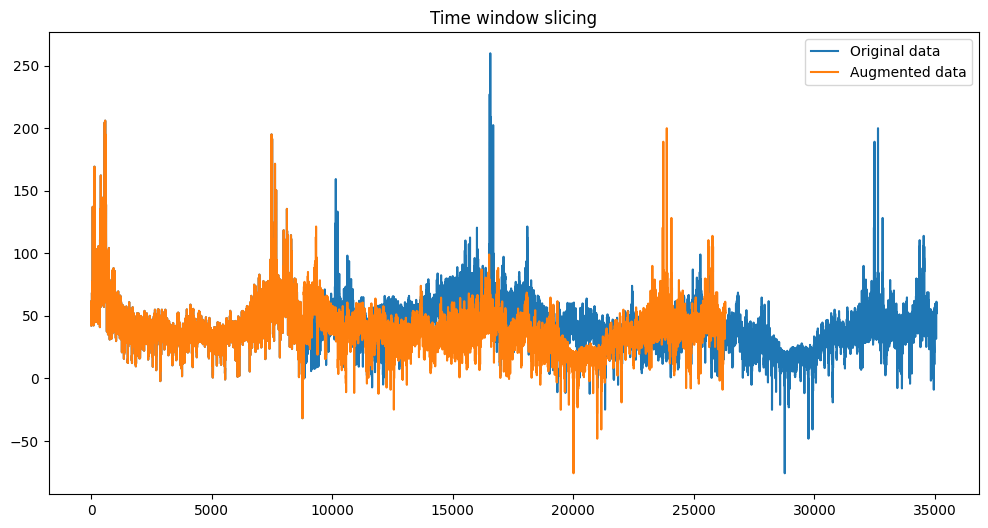

In [73]:
# plot the original and augmented time series
plt.figure(figsize=(12, 6))
plt.title('Time window slicing')
plt.plot(original_series, label='Original data')
plt.plot(augmented_series, label='Augmented data')
plt.legend()
plt.show()

In [74]:
from scipy.interpolate import CubicSpline

def magnitude_warping(time_series, num_knots=4, warp_std_dev=0.2):
    # Generating random spline knots within a time series
    knot_positions = np.linspace(0, len(time_series) - 1, num=num_knots)
    knot_values = 1 + np.random.normal(0, warp_std_dev, num_knots)

    # Creating a Cubic Spline Function Through Knots
    spline = CubicSpline(knot_positions, knot_values)

    # Generating time indexes for a time series
    time_indexes = np.arange(len(time_series))

    # Applying distortion to a time series
    warped_time_series = time_series * spline(time_indexes)

    return warped_time_series


augmented_series = magnitude_warping(original_series, num_knots=5, warp_std_dev=0.45)

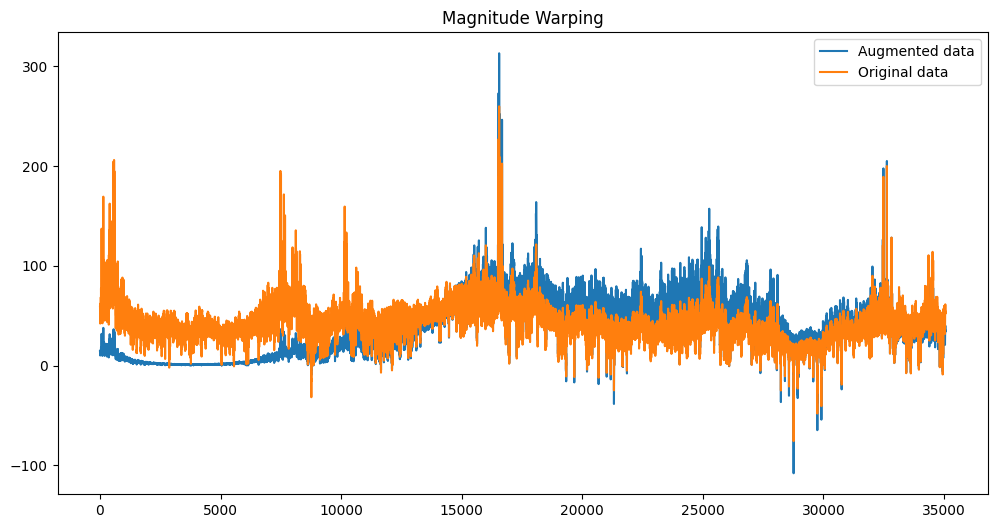

In [75]:
plt.figure(figsize=(12, 6))
plt.title("Magnitude Warping")
plt.plot(augmented_series, label="Augmented data")
plt.plot(original_series, label="Original data")
plt.legend()
plt.show()

In [76]:
import random

def time_warping(time_series, num_operations=10, warp_factor=0.2):
    warped_series = time_series.copy()
    for _ in range(num_operations):
        operation_type = random.choice(["insert", "delete"])
        index = random.randint(1, len(warped_series) - 2)
        if operation_type == "insert":
            # Insert a value by interpolating between two adjacent points
            insertion_value = (warped_series[index - 1] + warped_series[index]) * 0.5
            warp_amount = insertion_value * warp_factor * random.uniform(-1, 1)
            warped_series = np.insert(warped_series, index, insertion_value + warp_amount)
        elif operation_type == "delete":
            # Remove a random point
            warped_series = np.delete(warped_series, index)
        else:
            raise ValueError("Invalid operation type")

    return warped_series

augmented_series = time_warping(original_series, num_operations=20, warp_factor=0.25)
print(f"Original time series length: {len(original_series)}")
print(f"Augmented time series length: {len(augmented_series)}")

Original time series length: 35064
Augmented time series length: 35070


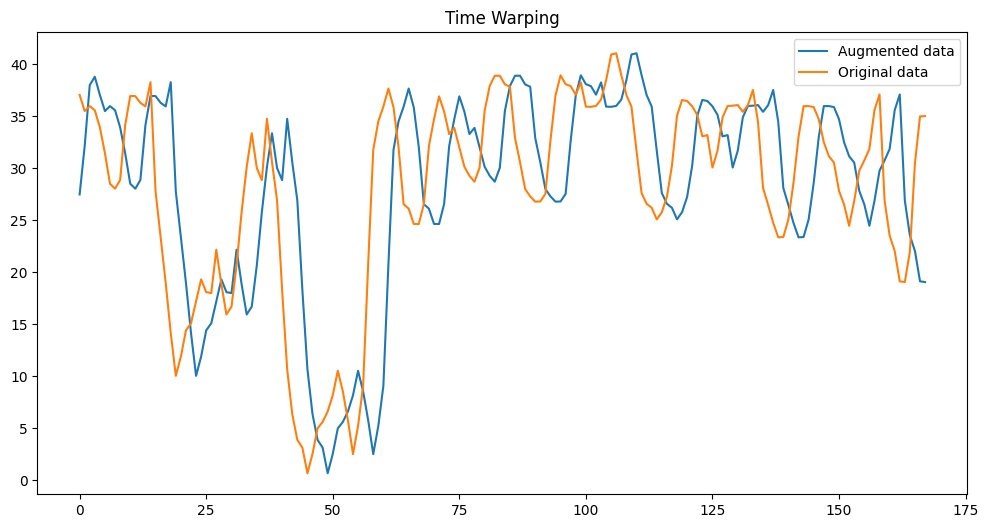

In [77]:
start = 5000
end = start + 24*7

plt.figure(figsize=(12, 6))
plt.title("Time Warping")
plt.plot(augmented_series[start:end], label="Augmented data")
plt.plot(original_series[start:end], label="Original data")
plt.legend()
plt.show()

In [78]:
def shuffle_time_slices(time_series, slice_size=1):
    if slice_size <= 0 or slice_size > len(time_series):
        raise ValueError("Slice size must be within the range 1 to len(data)")

    num_slices = len(time_series) // slice_size

    # Cut the data into slices
    slices = [time_series[i * slice_size:(i + 1) * slice_size] for i in range(num_slices)]

    # Shuffle the slices
    np.random.shuffle(slices)

    # Concatenate the shuffled slices
    shuffled_data = np.concatenate(slices)

    # Include any leftover data that couldn't form a complete slice
    remainder = len(time_series) % slice_size
    if remainder > 0:
        remainder_data = time_series[-remainder:]
        shuffled_data = np.concatenate([shuffled_data, remainder_data])

    return shuffled_data

augmented_series = shuffle_time_slices(original_series, slice_size=24*365)

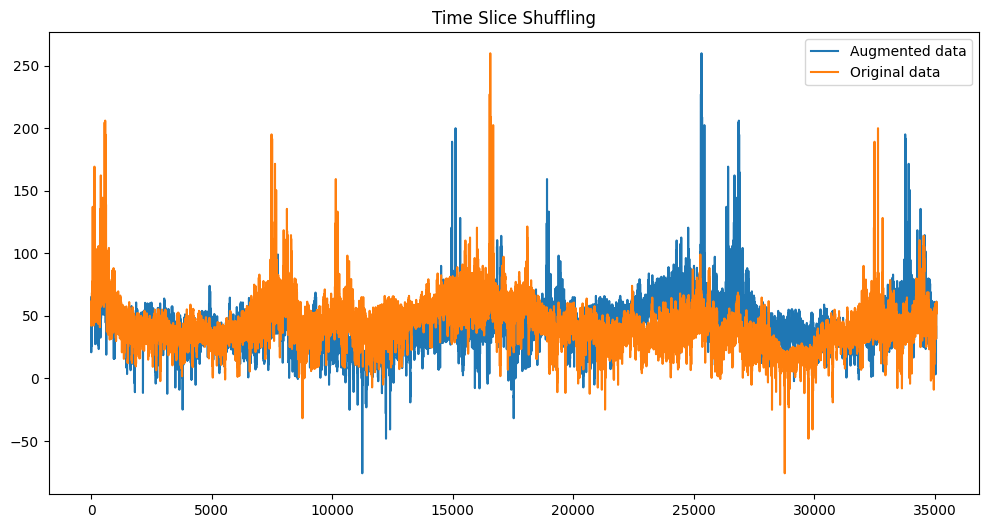

In [79]:
plt.figure(figsize=(12, 6))
plt.title("Time Slice Shuffling")
plt.plot(augmented_series, label="Augmented data")
plt.plot(original_series, label="Original data")
plt.legend()
plt.show()

In [80]:
def basic_augmentation(time_series):
    time_series = add_gaussian_noise(time_series, mean=0.0, stddev=0.05)
    time_series = magnitude_warping(time_series, num_knots=5, warp_std_dev=0.45)
    time_series = time_warping(time_series, num_operations=20, warp_factor=0.25)
    time_series = shuffle_time_slices(time_series, slice_size=24*365)
    return time_series

augmented_series = basic_augmentation(original_series)
print(f"Original time series length: {len(original_series)}")
print(f"Augmented time series length: {len(augmented_series)}")

Original time series length: 35064
Augmented time series length: 35060


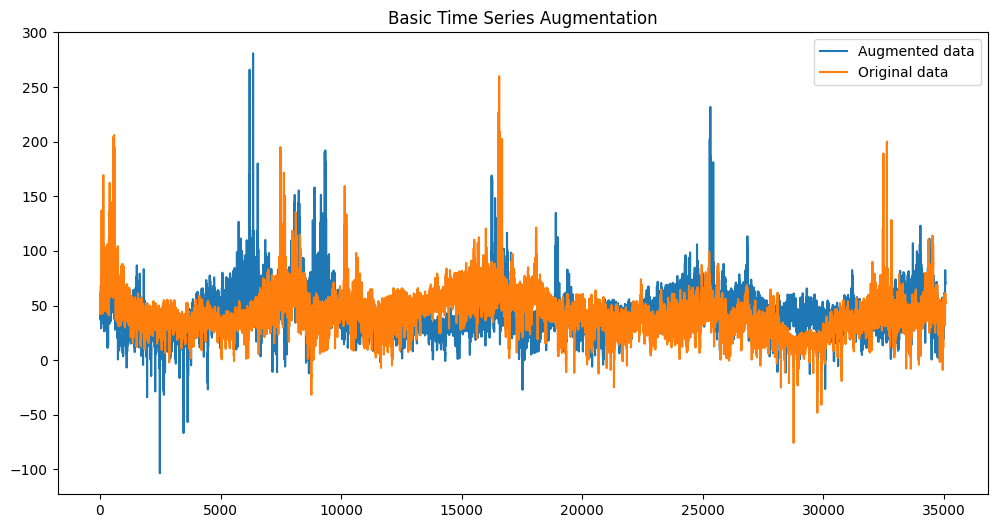

In [81]:
plt.figure(figsize=(12, 6))
plt.title("Basic Time Series Augmentation")
plt.plot(augmented_series, label="Augmented data")
plt.plot(original_series, label="Original data")
plt.legend()
plt.show()

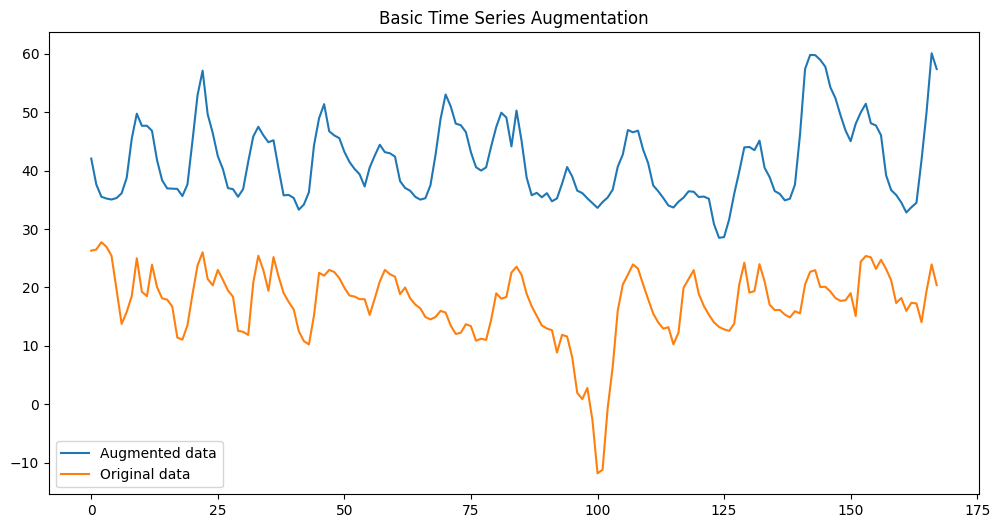

In [82]:
# zoom on a random week
start = random.randint(0, len(original_series) - 24*7)
end = start + 24*7
plt.figure(figsize=(12, 6))
plt.title("Basic Time Series Augmentation")
plt.plot(augmented_series[start:end], label="Augmented data")
plt.plot(original_series[start:end], label="Original data")
plt.legend()
plt.show()

## 3. Forecasting

### 3.1. Préparer les données

In [83]:
# get all the synthetic data
synthetic_series = []
for f in synthetic_data_filenames:
    data = pd.read_parquet(os.path.join(synthetic_data_path, f))
    synthetic_series.append(np.array(data['price']))

print(f"Loaded {len(synthetic_series)} synthetic scenarios")

Loaded 154 synthetic scenarios


In [84]:
# generate as many augmented scenarios
augmented_series = []
for i in range(len(synthetic_series)):
    augmented_series.append(basic_augmentation(original_series))

print(f"Generated {len(augmented_series)} new scenarios with basic augmentation")

Generated 154 new scenarios with basic augmentation


In [85]:
# Prepare the data
from tqdm import tqdm

def create_dataset(time_series, look_back=24, horizon=6, stride=1):
    X, y = [], []
    for i in range(0, len(time_series) - look_back - horizon + 1, stride):
        X.append(time_series[i:i + look_back])
        y.append(time_series[i + look_back:i + look_back + horizon])
    return np.array(X), np.array(y)

def create_dataset_from_scenarios(scenarios, look_back=24, horizon=6, stride=1):
    X, y = [], []
    for scenario in tqdm(scenarios):
        X_, y_ = create_dataset(scenario, look_back=look_back, horizon=horizon, stride=stride)
        X.append(X_)
        y.append(y_)
    return np.concatenate(X), np.concatenate(y)

(35035, 24) (35035, 6)


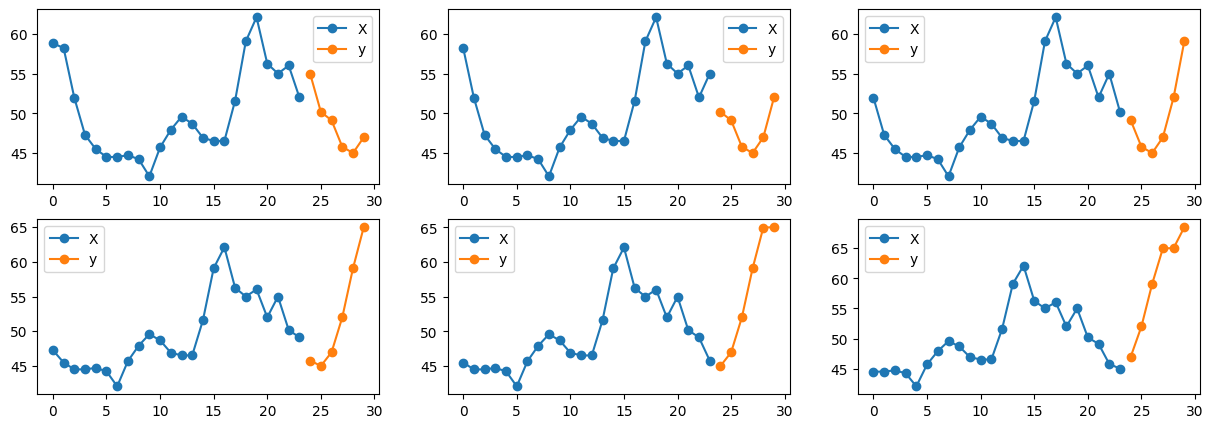

In [86]:
look_back = 24
horizon = 6

X, y = create_dataset(original_series, look_back, horizon)
print(X.shape, y.shape)

# plot the first 6 samples
_, axs = plt.subplots(2, 3, figsize=(15, 5))
axs = axs.flatten()
for i in range(6):
    axs[i].plot(X[i], marker='o', label='X')
    axs[i].plot(range(look_back, look_back + horizon), y[i], marker='o', label='y')
    axs[i].legend()
plt.show()


Horizons à tester :
- 6h
- 12h
- 24h (1 jour)
- 48h (2 jours)
- 168h (1 semaine)

### 3.2. LSTM

In [87]:
# Define LSTM model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def create_lstm_model(input_shape, output_sequence_length):
    model = keras.models.Sequential()
    model.add(layers.LSTM(64, input_shape=input_shape))
    model.add(layers.Dense(output_sequence_length))
    return model

2025-01-23 18:45:08.250703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737654308.264174    6004 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737654308.268167    6004 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 18:45:08.281838: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [88]:
def train_model(time_series, look_back=24, horizon=6, stride=1):
    X, y = create_dataset_from_scenarios(time_series, look_back=look_back, horizon=horizon, stride=stride)

    # Split the data into training and test sets
    train_size = int(0.8 * len(X))
    X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

    # Train the model
    model = create_lstm_model(input_shape=(look_back, 1), output_sequence_length=horizon)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

    print()
    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

    # Evaluate the model
    print()
    test_loss = model.evaluate(X_test, y_test)
    print(f"Test loss: {test_loss}\n")

    return model

In [89]:
def forecast(model, time_series, look_back=24, horizon=6):
    X, y = create_dataset(time_series, look_back=look_back, horizon=horizon)
    y_pred = model.predict(X)
    return X, y, y_pred

In [90]:
def plot_forecast(X, y, y_pred, look_back=24, horizon=6):
    y_pred = np.concatenate((X[-1:], y_pred))
    X = np.concatenate((X, y))
    plt.plot(X, label='Actual')
    plt.plot(range(look_back-1, look_back+horizon), y_pred, label='Forecast')
    plt.axvline(x=look_back, color='k', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()

In [91]:
LOOK_BACK = 24
HORIZON = 6

In [92]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


W0000 00:00:1737654310.071853    6004 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### 3.3. Using the original data

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

print(tf.__version__)

# Modèle minimal
model = Sequential([
    LSTM(64, input_shape=(10, 1)),  # Exemple d'entrée avec look_back=10
    Dense(1)  # Exemple de sortie univariée
])

model.compile(optimizer='adam', loss='mse')
print(model.summary())


2.18.0


/root/anaconda3/AirLiquide_data-augmentation/.conda/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [94]:
model_original = train_model([original_series], look_back=LOOK_BACK, horizon=HORIZON)
X, y, y_pred_original = forecast(model_original, original_series, look_back=LOOK_BACK, horizon=HORIZON)

100%|██████████| 1/1 [00:00<00:00, 29.28it/s]



Epoch 1/5
701/701 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 1618.6780 - val_loss: 116.9625
Epoch 2/5
701/701 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 328.0082 - val_loss: 68.6869
Epoch 3/5
701/701 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 174.5233 - val_loss: 54.0429
Epoch 4/5
701/701 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 124.8042 - val_loss: 50.7940
Epoch 5/5
701/701 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 105.1919 - val_loss: 46.6758

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 47.6687
Test loss: 63.75086212158203

1095/1095 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


### 3.4. Using augmented data

Avec `stride=30`, on a $\frac{\text{nb scénarios}}{\text{stride}}\approx 5$ fois plus de données que dans le dataset original.

Si `LOOK_BACK`+`HORIZON`=`stride`, alors le modèle voit une seule fois chaque heure de chaque scénario.

In [95]:
model_augmented = train_model(augmented_series, look_back=LOOK_BACK, horizon=HORIZON, stride=30)
X, y, y_pred_augmented = forecast(model_augmented, original_series, look_back=LOOK_BACK, horizon=HORIZON)

100%|██████████| 154/154 [00:00<00:00, 983.67it/s]



Epoch 1/5
3598/3598 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 974.7437 - val_loss: 118.9180
Epoch 2/5
3598/3598 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 119.5128 - val_loss: 78.0851
Epoch 3/5
3598/3598 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 82.8358 - val_loss: 64.8135
Epoch 4/5
3598/3598 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 72.7280 - val_loss: 64.0699
Epoch 5/5
3598/3598 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 68.7264 - val_loss: 62.8049

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 69.8041
Test loss: 64.48845672607422

1095/1095 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


### 3.5. Using synthetic data

In [96]:
model_synthetic = train_model(synthetic_series, look_back=LOOK_BACK, horizon=HORIZON, stride=30)
X, y, y_pred_synthetic = forecast(model_synthetic, original_series, look_back=LOOK_BACK, horizon=HORIZON)

100%|██████████| 154/154 [00:00<00:00, 968.34it/s]



Epoch 1/5
3586/3586 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 587.3288 - val_loss: 76.9303
Epoch 2/5
3586/3586 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 65.5894 - val_loss: 56.1234
Epoch 3/5
3586/3586 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 52.6341 - val_loss: 47.9872
Epoch 4/5
3586/3586 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - loss: 47.3079 - val_loss: 44.8504
Epoch 5/5
3586/3586 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 44.3809 - val_loss: 43.5918

1121/1121 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 42.3272
Test loss: 43.075321197509766

1095/1095 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


## 4. Compare results

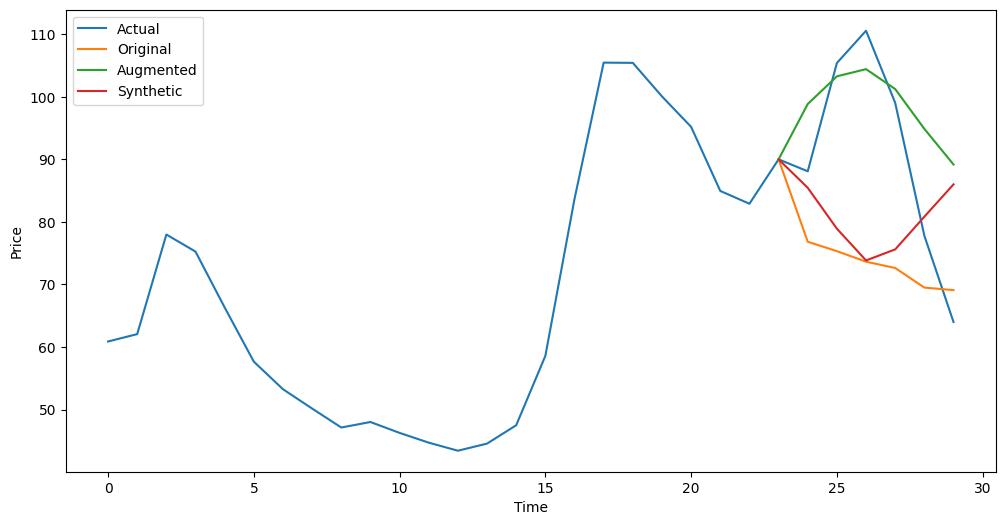

In [97]:
# plot a prediction
random_index = np.random.randint(0, len(X))
X_sample = X[random_index]
y_sample = y[random_index]

plt.figure(figsize=(12, 6))
plt.plot(np.concatenate((X_sample, y_sample)), label='Actual')

predictions = [y_pred_original, y_pred_augmented, y_pred_synthetic]
labels = ['Original', 'Augmented', 'Synthetic']
for y_pred, label in zip(predictions, labels):
    y_pred = np.concatenate((X_sample[-1:], y_pred[random_index]))
    plt.plot(range(LOOK_BACK-1, LOOK_BACK+HORIZON), y_pred, label=label)

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [98]:
# Loop over different horizons
# horizons = [6, 12, 24, 48, 168]

def forecast_multiple_steps(model, hours_ahead=6):
    steps_ahead = hours_ahead // HORIZON
    X, y = create_dataset(original_series, look_back=look_back, horizon=horizon)
    predictions = np.zeros((len(X), hours_ahead))
    for step in range(steps_ahead):
        # predict the next horizon
        y_pred = model.predict(X)
        predictions[:,step*HORIZON:(step+1)*HORIZON] = y_pred
        # add prediction to the input to forecast further into the future
        X = np.concatenate((X, y_pred), axis=1)
    print()
    return predictions

In [99]:
pred_original = forecast_multiple_steps(model_original, hours_ahead=168)
pred_augmented = forecast_multiple_steps(model_augmented, hours_ahead=168)
pred_synthetic = forecast_multiple_steps(model_synthetic, hours_ahead=168)

1095/1095 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 14s 

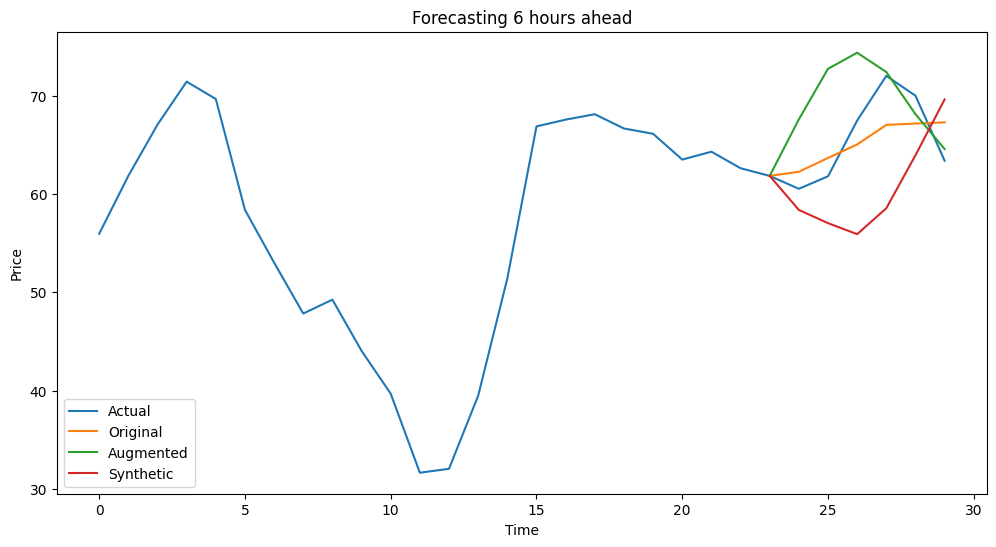

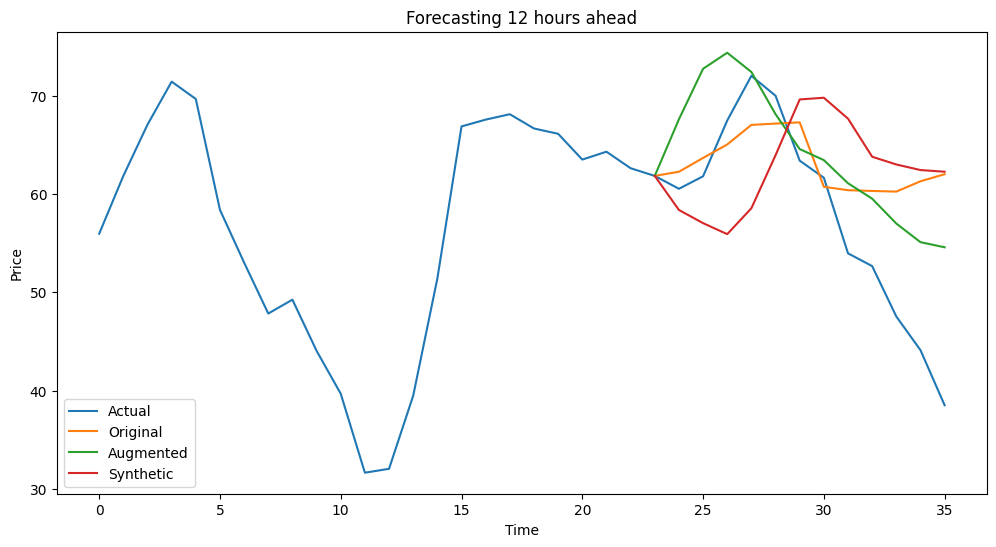

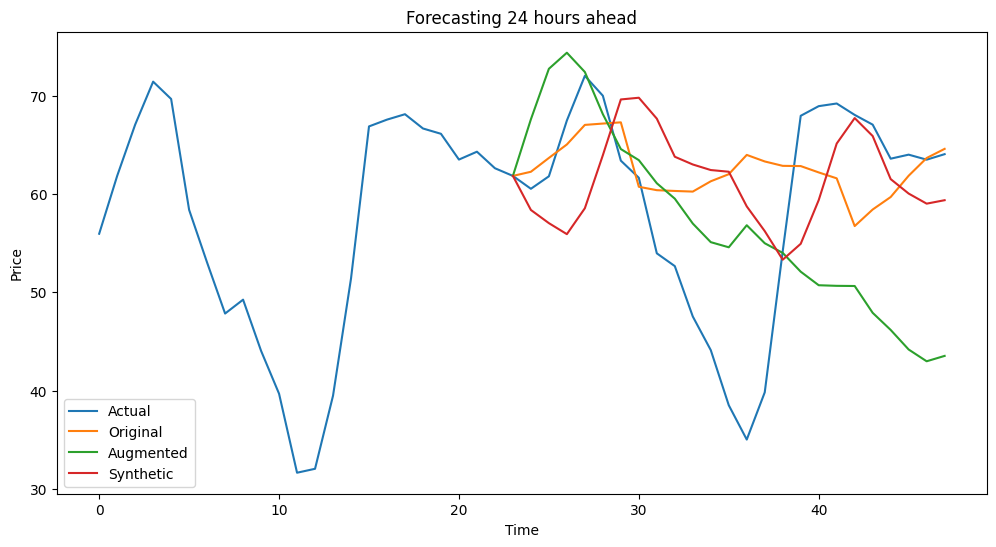

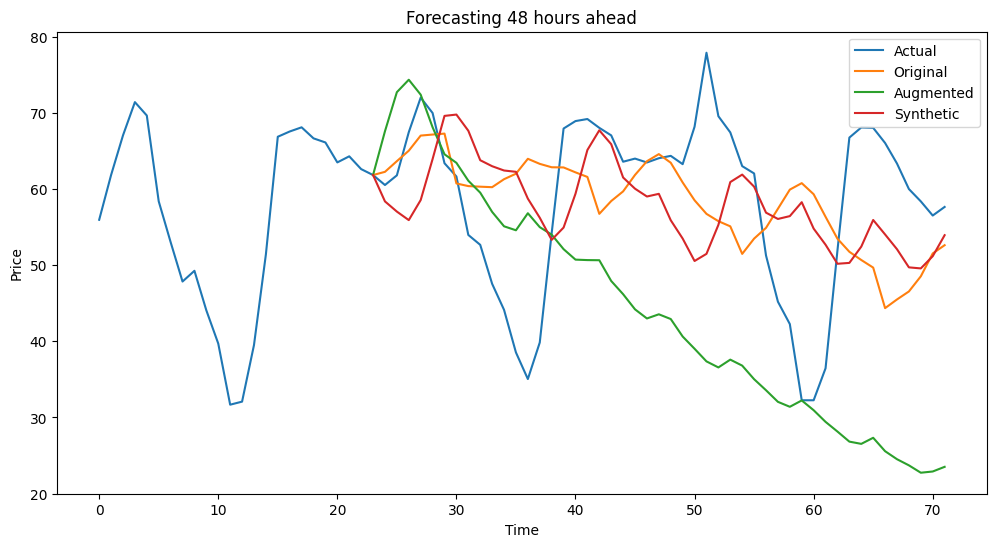

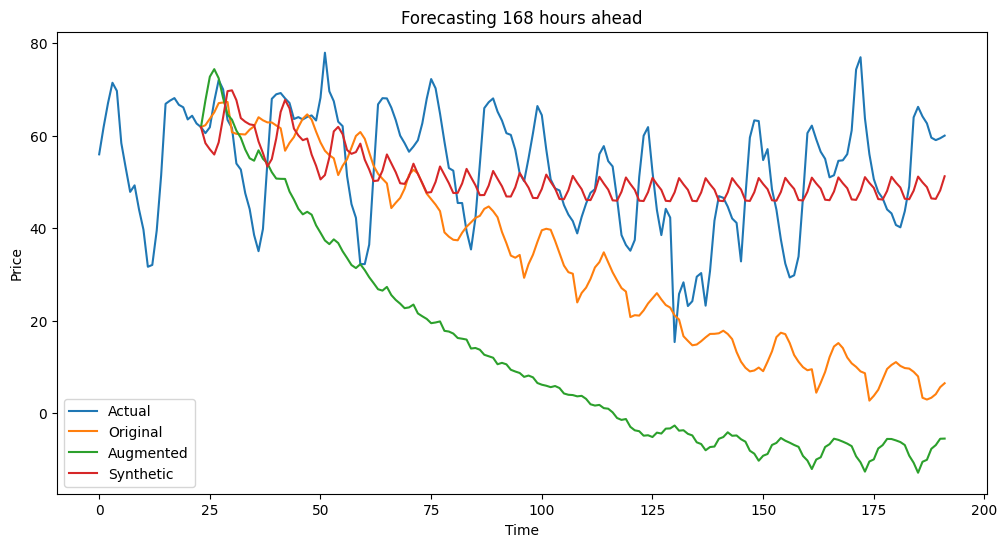

In [100]:
X, y = create_dataset(original_series, look_back=look_back, horizon=168)

# plot random sample
random_index = np.random.randint(0, len(X))
X_sample = X[random_index]
y_sample = y[random_index]

predictions = [pred_original, pred_augmented, pred_synthetic]
labels = ['Original', 'Augmented', 'Synthetic']

def plot_forecast_multiple_steps(hours_ahead):
    plt.figure(figsize=(12, 6))
    plt.plot(np.concatenate((X_sample, y_sample[:hours_ahead])), label='Actual')
    for y_pred, label in zip(predictions, labels):
        y_pred = np.concatenate((X_sample[-1:], y_pred[random_index][:hours_ahead]))
        plt.plot(range(LOOK_BACK-1, LOOK_BACK+hours_ahead), y_pred, label=label)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()

for hours_ahead in [6, 12, 24, 48, 168]:
    plot_forecast_multiple_steps(hours_ahead)
    plt.title(f"Forecasting {hours_ahead} hours ahead")
    plt.show()
